In [1]:
import torch
import random

import numpy as np
import torch.nn as nn

from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True # this can slow down speed
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

#### Dataset 및 DataLoader 정의

In [3]:
# CatDogDataset
import torchvision.transforms as tf

from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):
    def __init__(self, mode):
      # mode에 따른 root 경로 설정
      if mode == 'train':
        self.root_path = './data/dog_cat/train'
        self.transform = tf.Compose([
                                    # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                    tf.RandomResizedCrop((32,32)),
                                    tf.RandomHorizontalFlip(p=0.5),
                                    tf.ToTensor()
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                  ])
      else:
        self.root_path = './data/dog_cat/test'
        self.transform = tf.Compose([
                                    tf.Resize(size=(32,32)),
                                    tf.ToTensor(),
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                     ])
        
      # 모드에 맞는 고양이 이미지 경로 생성
      cat_img_path = glob(f'./data/dog_cat/{mode}/cat/*')
      cat_labels = [0]*len(cat_img_path)
    
      # 모드에 맞는 강아지 이미지 경로 생성
      dog_img_path = glob(f'./data/dog_cat/{mode}/dog/*')
      dog_labels = [1]*len(dog_img_path)
    
      # 이미지 경로 및 레이블 합치기
      self.img_path = cat_img_path + dog_img_path
      self.labels = cat_labels + dog_labels

    def __len__(self):
      return len(self.img_path)
    
    def __getitem__(self,idx):
      crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
      img = Image.open(crt_img_path) # 이미지 오픈
      X = self.transform(img) # 이미지 변형
      
      y = self.labels[idx]
      
      return X, y

In [4]:
# 학습/테스트 데이터셋 및 데이터로더 생성
trainset = CatDogDataset(mode='train')
testset = CatDogDataset(mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

In [5]:
print(trainset.__len__())
print(testset.__len__())

202
102


#### 모델 정의

In [6]:
class MyLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
                           nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1),padding=(0,0)), # C1 layer
                           nn.BatchNorm2d(num_features=6),
                           nn.ReLU(True),
                           # nn.Dropout(p=0.1),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0))) # S2 layer
        
        self.block2 = nn.Sequential(
                           nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0)), # C3 layer
                           nn.BatchNorm2d(num_features=16),
                           nn.ReLU(True),
                           # nn.Dropout(p=0.1),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0))) # S4 layer
        
        self.block3 = nn.Sequential(
                            nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0)), # C5 layer
                            nn.BatchNorm2d(num_features=120),
                            nn.ReLU(True))
        
        self.fc1 = nn.Sequential(nn.Linear(120,84), nn.ReLU(True))
        self.fc2 = nn.Linear(84,num_classes)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 32, 32
        out = self.block1(x) # B, 6, 14, 14
        out = self.block2(out) # B, 16, 5, 5
        out = self.block3(out) # B, 120, 1
        out = self.flatten(out) # B, 120
        out = self.fc1(out) # B, 64
        out = self.fc2(out) # B, num_classes
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [7]:
summary(MyLeNet(num_classes=2), input_data=(3,32,32), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 6, 14, 14]           --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           456
|    └─BatchNorm2d: 2-2                  [-1, 6, 28, 28]           12
|    └─ReLU: 2-3                         [-1, 6, 28, 28]           --
|    └─MaxPool2d: 2-4                    [-1, 6, 14, 14]           --
├─Sequential: 1-2                        [-1, 16, 5, 5]            --
|    └─Conv2d: 2-5                       [-1, 16, 10, 10]          2,416
|    └─BatchNorm2d: 2-6                  [-1, 16, 10, 10]          32
|    └─ReLU: 2-7                         [-1, 16, 10, 10]          --
|    └─MaxPool2d: 2-8                    [-1, 16, 5, 5]            --
├─Sequential: 1-3                        [-1, 120, 1, 1]           --
|    └─Conv2d: 2-9                       [-1, 120, 1, 1]           48,120
|    └─BatchNorm2d: 2-10                 [-1, 120, 1, 1]           240
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 6, 14, 14]           --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           456
|    └─BatchNorm2d: 2-2                  [-1, 6, 28, 28]           12
|    └─ReLU: 2-3                         [-1, 6, 28, 28]           --
|    └─MaxPool2d: 2-4                    [-1, 6, 14, 14]           --
├─Sequential: 1-2                        [-1, 16, 5, 5]            --
|    └─Conv2d: 2-5                       [-1, 16, 10, 10]          2,416
|    └─BatchNorm2d: 2-6                  [-1, 16, 10, 10]          32
|    └─ReLU: 2-7                         [-1, 16, 10, 10]          --
|    └─MaxPool2d: 2-8                    [-1, 16, 5, 5]            --
├─Sequential: 1-3                        [-1, 120, 1, 1]           --
|    └─Conv2d: 2-9                       [-1, 120, 1, 1]           48,120
|    └─BatchNorm2d: 2-10                 [-1, 120, 1, 1]           240
|    └

In [8]:
model = MyLeNet(num_classes=2)

#### Optimizer 정의

In [9]:
# loss.backward를 통해서 gradient를 계산하고 실제로 파라미터를 업데이트 하는 역할

sgd = torch.optim.SGD(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01, # 학습률
                      momentum=0.9 # 과거 그레디언트 가중합 파라미터
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

adam = torch.optim.Adam(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01 # 학습률
                      # betas=(0.9,0.999) # (momentum, adaptive lr momentum)
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

del sgd, adam

optimizer = torch.optim.SGD(params=model.parameters(),
                      lr=0.003,
                      momentum=0.9,
                      weight_decay=5e-4
                      )

#### Loss 함수 정의

In [10]:
mse_fn = nn.MSELoss()
ce_fn = nn.CrossEntropyLoss()
bce_fn = nn.BCELoss() # Binary cross-entropy loss

del mse_fn, ce_fn, bce_fn

loss_fn = nn.CrossEntropyLoss()

#### To Device

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# 모델 파라미터를 device로 이동
model.to(device)

# loss function을 device로 이동
loss_fn.to(device)

CrossEntropyLoss()

#### 역전파 알고리즘

In [12]:
import time

epochs = 100
best_acc = 0.
train_history = {'loss':[],'acc':[]}
test_history = {'loss':[],'acc':[]}

for epoch in range(epochs): # 학습 데이터셋 전체를 몇 번 학습시킬건지
    train_loss, test_loss = 0.0, 0.0
    train_acc, test_acc = 0.0, 0.0
    n_train, n_test = 0, 0
    start = time.time()
    
    # training
    model.train()
    for (imgs, targets) in trainloader: # 학습 데이터셋에서 batch size만큼 가져오기
        
        # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # train 정보 저장
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / n_train
    
    # testing
    model.eval()
    with torch.no_grad():
        for (imgs, targets) in testloader:
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            outputs = model(imgs) # B,2
            
            loss = loss_fn(outputs, targets)

            # loss 저장
            test_loss += loss.item()
            
            # 정확도 저장
            preds = torch.max(outputs, dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            test_acc += acc
            n_test += targets.shape[0]
    
    # test 정보 저장
    test_loss = test_loss / len(testloader)
    test_acc = test_acc / n_test
    
    # best model일 경우 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch+1
        save_dict = {'model':model.state_dict(),
                     'optimizer':optimizer.state_dict(),
                     'epoch':best_epoch,
                     'acc':best_acc}
        torch.save(save_dict, './catdog_lenet.pt')
        
    # 학습/테스트에 소요된 시간 계산
    epoch_time = time.time() - start
    
    # 학습 정보 출력
    print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
    print(f'Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')
    print(f'Train ACC : {train_acc:.4f} | Test ACC : {test_acc:.4f} \n')

    # 에폭별 학습 정보 저장
    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    test_history['loss'].append(test_loss)
    test_history['acc'].append(test_acc)

# 학습 종료
print('-'*50)
print('Dataset  : DogCat | Model : LeNet5')
print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch}')
    

Epoch     :      1 | Time     : 1.00 sec
Train Loss: 0.8385 | Test Loss: 0.6944
Train ACC : 0.4653 | Test ACC : 0.4510 

Epoch     :      2 | Time     : 0.50 sec
Train Loss: 0.7829 | Test Loss: 0.7064
Train ACC : 0.5149 | Test ACC : 0.5196 

Epoch     :      3 | Time     : 0.48 sec
Train Loss: 0.7199 | Test Loss: 0.7058
Train ACC : 0.5891 | Test ACC : 0.4804 

Epoch     :      4 | Time     : 0.47 sec
Train Loss: 0.7049 | Test Loss: 0.6895
Train ACC : 0.5198 | Test ACC : 0.5686 

Epoch     :      5 | Time     : 0.45 sec
Train Loss: 0.6836 | Test Loss: 0.6633
Train ACC : 0.5941 | Test ACC : 0.5588 

Epoch     :      6 | Time     : 0.45 sec
Train Loss: 0.7116 | Test Loss: 0.6556
Train ACC : 0.5644 | Test ACC : 0.6176 

Epoch     :      7 | Time     : 0.46 sec
Train Loss: 0.6570 | Test Loss: 0.6946
Train ACC : 0.5842 | Test ACC : 0.5588 

Epoch     :      8 | Time     : 0.45 sec
Train Loss: 0.6710 | Test Loss: 0.7413
Train ACC : 0.5941 | Test ACC : 0.5196 

Epoch     :      9 | Time     : 

Epoch     :     69 | Time     : 0.47 sec
Train Loss: 0.5546 | Test Loss: 0.6375
Train ACC : 0.7475 | Test ACC : 0.5980 

Epoch     :     70 | Time     : 0.46 sec
Train Loss: 0.6009 | Test Loss: 0.8748
Train ACC : 0.7376 | Test ACC : 0.6078 

Epoch     :     71 | Time     : 0.46 sec
Train Loss: 0.5498 | Test Loss: 1.0066
Train ACC : 0.7475 | Test ACC : 0.5882 

Epoch     :     72 | Time     : 0.45 sec
Train Loss: 0.5593 | Test Loss: 0.7753
Train ACC : 0.7426 | Test ACC : 0.5784 

Epoch     :     73 | Time     : 0.46 sec
Train Loss: 0.5635 | Test Loss: 0.6706
Train ACC : 0.7277 | Test ACC : 0.5588 

Epoch     :     74 | Time     : 0.46 sec
Train Loss: 0.4954 | Test Loss: 0.6881
Train ACC : 0.7624 | Test ACC : 0.5588 

Epoch     :     75 | Time     : 0.47 sec
Train Loss: 0.4783 | Test Loss: 0.7171
Train ACC : 0.7475 | Test ACC : 0.6078 

Epoch     :     76 | Time     : 0.46 sec
Train Loss: 0.4907 | Test Loss: 0.7078
Train ACC : 0.7030 | Test ACC : 0.6569 

Epoch     :     77 | Time     : 

#### 학습 추세 시각화

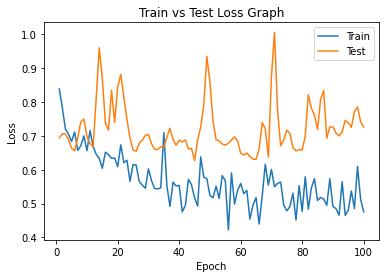

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1,epochs+1),y=train_history['loss'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=test_history['loss'], label='Test')
plt.title('Train vs Test Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

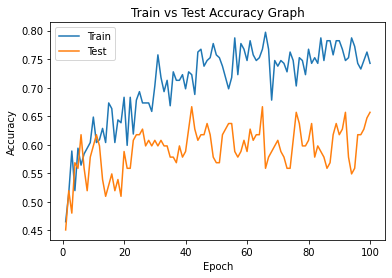

In [14]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=test_history['acc'], label='Test')
plt.title('Train vs Test Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()